---

<center><h1> Building More Models to Predict Housing Prices </h1></center>

---


## Packages Used:


In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# For Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Manipulating and Storing Data
import pandas as pd
import numpy as np
pd.set_option('display.max_columns',None)

# Machine Learning
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import ensemble

---
## Condensed Data Cleaning Pipeline


In [2]:
def fill_median_by_category(df,nan_column,category):    
    means = df.groupby(category)[nan_column].median()
    df.set_index([category],inplace=True)
    df[nan_column] = df[nan_column].fillna(means)
    df.reset_index(inplace=True)
    print(f"Filled NaNs in '{nan_column}' column with medians of respective '{category}' category")
    return

In [3]:
df = pd.read_csv('melb_data.csv')

df['Regionname'] , _ = pd.factorize(df['Regionname'])
df['Type'], _ = pd.factorize(df['Type'])

df = df.drop(columns=['Bedroom2'])
df['Landsize'] = df['Landsize'].replace(0,np.nan)
df['BuildingArea'] = df['BuildingArea'].replace(0,np.nan)

nan_cols = [col for col in df.columns if df[col].isna().any()]
nan_cols.remove('CouncilArea')

# Fill NaNs
for col in nan_cols:
    # Fill with median of postalcode
    fill_median_by_category(df,col,'Postcode')
    
    # If still nans fill with global median of column
    fill = df[col].median()
    df[col] = df[col].fillna(fill)

Filled NaNs in 'Car' column with medians of respective 'Postcode' category
Filled NaNs in 'Landsize' column with medians of respective 'Postcode' category
Filled NaNs in 'BuildingArea' column with medians of respective 'Postcode' category
Filled NaNs in 'YearBuilt' column with medians of respective 'Postcode' category


## Using Cross Validation to Better Understand Our Models

In [4]:
rs = 5

# Create list of dependent features to use in baseline model
num_features = ['Rooms',
            'Distance',
            'Bathroom',
            'Car',
            'Landsize',
            'BuildingArea',
            'Lattitude',
            'Longtitude',
            'YearBuilt',
           ]

categorical_features = ['Type','Regionname']

features = num_features + categorical_features

# identify target (independent) variable
target = 'Price'

In [5]:
from sklearn.model_selection import KFold

Using the KFold module we can split our data into the necessary train and validation indices for cross validation of our models. Lets take a look at how to use KFold in practice.

In [6]:
folds = KFold(n_splits = 5,random_state=rs)
indices = folds.split(df)

Here we split our data frame using folds.split() method of the folds object. Lets look at what data type it represents.

In [7]:
type(indices)

generator

Our "indices" object represents a generator, lets iterate through it and see what each item is in the generator.

In [8]:
for i in indices:
    print(type(i))
    break

<class 'tuple'>


Okay each item in the generator is a tuple. Lets check the size of each tuple.

In [9]:
for i in indices:
    print(len(i))
    break

2


finally lets look into each tuple and check their respective lengths relative to the total DataFrame.

In [10]:
folds = KFold(n_splits = 5,random_state=rs)
indices = folds.split(df)

for a,b in indices:
    print(len(a)/len(df))
    print(len(b)/len(df))

0.8
0.2
0.8
0.2
0.8
0.2
0.8
0.2
0.8
0.2


The folds provide us with a list of indices for the train and validation set. Now we understand better how KFold actually splits the data and what objects it returns to us. We are now ready to use KFold in order to cross validate our model. One of the uses of this is that we can grab attributes from each fold so we can get things like feature importance and different loss values over each fold. Below we will walkthrough one method on how to calculate the mean feature importance of our model over every fold.

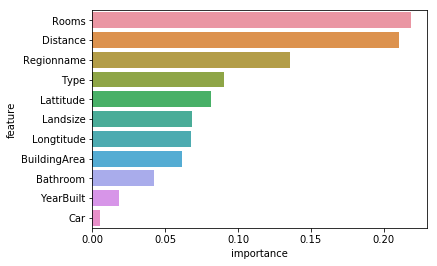

In [11]:
folds = KFold(n_splits = 5)
indices = folds.split(df)

feature_importance = pd.DataFrame()
feature_importance['feature'] = features
feature_importance['importance'] = np.zeros(len(features))

for train_idx,val_idx in indices:
    
    train = df.iloc[train_idx]
    val = df.iloc[val_idx]
    
    dt = tree.DecisionTreeRegressor(max_depth=10,random_state=rs)
    dt_model = dt.fit(train[features],train[target])
    
    feature_importance['importance'] += dt_model.feature_importances_/folds.n_splits
    
sns.barplot(x='importance',y='feature',data=feature_importance.sort_values('importance',ascending=False));

## Out of Fold Validation

Generally when we get a prediction from a cross validation function it is giving us an "out of fold" prediction. What this means is that it is taking the predictions of each model on the validation set and returning those predictions. With this method we get a prediction for every point in our training set. This is often abbreviated to oof score or oof predictions. Here is how we would grab these scores manually.

In [12]:
folds = KFold(n_splits = 5)
indices = folds.split(df)

oof_preds = np.zeros(len(df))

for train_idx,val_idx in indices:
    train = df.iloc[train_idx]
    val = df.iloc[val_idx]
    dt = tree.DecisionTreeRegressor(max_depth=10,random_state=rs)
    dt_model = dt.fit(train[features],train[target])
    
    oof_preds[val_idx] = dt_model.predict(val[features])

In [13]:
print('Out of Fold R-Squared:',r2_score(df[target],oof_preds))

Out of Fold R-Squared: 0.6382598554176062


## Getting Test Set Predictions from Cross Validation

Another thing we can do when we cross validate is to get a prediction on our test set. This is technically a form of ensembling as we are taking the predictions from each model trained in each fold. We do this similar to how we did mean feature importance across the folds. But first we will need to split our data into train and test sets.

In [14]:
train_df,test_df = train_test_split(df,test_size=0.2,random_state=rs)

folds = KFold(n_splits = 5,shuffle=True,random_state=rs)
indices = folds.split(train_df)

oof_preds = np.zeros(len(train_df))
test_preds = np.zeros(len(test_df))

for train_idx,val_idx in indices:
    
    train = train_df.iloc[train_idx]
    val = train_df.iloc[val_idx]
    
    dt = tree.DecisionTreeRegressor(max_depth=10,random_state=rs)
    dt_model = dt.fit(train[features],train[target])
    
    oof_preds[val_idx] = dt_model.predict(val[features])
    test_preds += dt_model.predict(test_df[features])/folds.n_splits
    
print('Out of Fold R-Squared',r2_score(train_df[target],oof_preds))
print('Test R-Squared',r2_score(test_df[target],test_preds))

Out of Fold R-Squared 0.6616481133898594
Test R-Squared 0.7211088703615105


Our model performs much better on the test set compared to the validation set, a testimate to the advantage of ensembling. This type of validation is generally a go to for accurate prediction of test set performance. We have now covered three different aggregates we can calculate using cross validation:

1. Mean Feature Importance
2. Out of Fold Predictions/Scores
3. Ensembled Test Set Predictions

Lets combine these into a single usable function that will work for any tree based model.

In [15]:
def cv_tree_model(model,train_df,test_df,features,folds = 5,state=1):
    
    folds = KFold(n_splits = folds,shuffle=True,random_state=state)
    indices = folds.split(train_df)

    oof_preds = np.zeros(len(train_df))
    test_preds = np.zeros(len(test_df))
    
    feature_importance = pd.DataFrame()
    feature_importance['feature'] = features
    feature_importance['importance'] = np.zeros(len(features))

    for train_idx,val_idx in indices:
        
        train = train_df.iloc[train_idx]
        val = train_df.iloc[val_idx]
        tree_model = model.fit(train[features],train[target])
        oof_preds[val_idx] = tree_model.predict(val[features])
        test_preds += tree_model.predict(test_df[features])/folds.n_splits
        feature_importance['importance'] += tree_model.feature_importances_/folds.n_splits
    
    feature_importance.sort_values('importance',ascending=False,inplace=True)
    
    print('Out of Fold R-Squared',r2_score(train_df[target],oof_preds))
    print('Test R-Squared',r2_score(test_df[target],test_preds))
    return oof_preds, test_preds, feature_importance        

Great now we have a function that can pass us any values we might need. Lets try this out on a few different tree based models and see how it does. 

GradientBoosting 
----------------------------------------
Out of Fold R-Squared 0.8064590963490588
Test R-Squared 0.7785659836904625


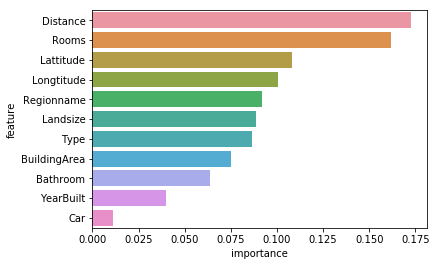

RandomForest 
----------------------------------------
Out of Fold R-Squared 0.7723476198592635
Test R-Squared 0.7415385666607512


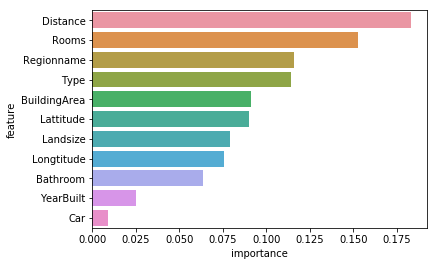

DecisionTree 
----------------------------------------
Out of Fold R-Squared 0.6616481133898594
Test R-Squared 0.7211088703615105


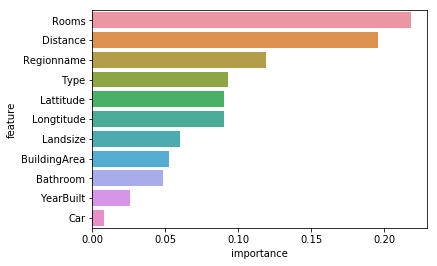

In [16]:
gbm = ensemble.GradientBoostingRegressor(max_depth=10,random_state=rs)
rf = ensemble.RandomForestRegressor(max_depth = 10,random_state=rs)
dt = tree.DecisionTreeRegressor(max_depth = 10,random_state=rs)

for model,name in zip([gbm,rf,dt],['GradientBoosting','RandomForest','DecisionTree']):
    print(name,'\n'+'-'*40)
    oofs,preds,feature_importance = cv_tree_model(model,train_df,test_df,features,folds = 5,state=rs)
    sns.barplot(x='importance',y='feature',data=feature_importance)
    plt.show()

---